In [1]:
import btQuant
import yfinance as yf 
import pandas as pd 
import numpy as np
import sklearn 

In [2]:
Price = yf.download("MSTR",period="5y")
Price = pd.DataFrame(Price)
Price = Price["Close"].values.tolist()


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Price = scaler.fit_transform(Price)



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
def fit_markov_switching(series, k_regimes=2, max_iter=100, tol=1e-6):
    """
    Fits a Markov Switching model to the given time series data.
    This model assumes 'k_regimes' number of regimes (hidden states).
    
    Parameters:
        series (array-like): A 1D array or list containing the time series data.
        k_regimes (int): Number of hidden regimes (states) in the Markov model.
        max_iter (int): Maximum number of iterations for the EM algorithm.
        tol (float): Convergence tolerance for the EM algorithm.
        
    Returns:
        dict: A dictionary containing:
            - 'params': The model parameters (mean, variance, and transition probabilities for each regime).
            - 'smoothed_probs': The smoothed marginal probabilities for each regime at each time step.
            - 'llf': The log-likelihood of the fitted model.
    """

    series = np.array(series)
    n = len(series)
    
    means = np.random.randn(k_regimes)
    variances = np.random.rand(k_regimes)
    transition_probs = np.ones((k_regimes, k_regimes)) / k_regimes

    state_probs = np.random.rand(n, k_regimes)
    state_probs /= state_probs.sum(axis=1, keepdims=True)
    
    log_likelihood = 0
    prev_log_likelihood = -np.inf
    
    for iteration in range(max_iter):
        
        forward_probs = np.zeros((n, k_regimes))
        backward_probs = np.zeros((n, k_regimes)) 
        
        for state in range(k_regimes):
            forward_probs[0, state] = (1 / np.sqrt(2 * np.pi * variances[state])) * \
                                      np.exp(-(series[0] - means[state])**2 / (2 * variances[state]))
        
        forward_probs[0] /= forward_probs[0].sum()
        
        for t in range(1, n):
            for state in range(k_regimes):
                forward_probs[t, state] = np.sum(forward_probs[t-1] * transition_probs[:, state]) * \
                                          (1 / np.sqrt(2 * np.pi * variances[state])) * \
                                          np.exp(-(series[t] - means[state])**2 / (2 * variances[state]))
            forward_probs[t] /= forward_probs[t].sum()
        
        backward_probs[-1] = 1 
        
        for t in range(n-2, -1, -1):
            for state in range(k_regimes):
                backward_probs[t, state] = np.sum(transition_probs[state] * backward_probs[t+1] *
                                                   (1 / np.sqrt(2 * np.pi * variances) *
                                                    np.exp(-(series[t+1] - means) ** 2 / (2 * variances))))
            backward_probs[t] /= backward_probs[t].sum()
        
        smoothed_probs = forward_probs * backward_probs
        smoothed_probs /= smoothed_probs.sum(axis=1, keepdims=True) 
        
        transition_probs = np.zeros((k_regimes, k_regimes))
        for t in range(n-1):
            for current_state in range(k_regimes):
                for next_state in range(k_regimes):
                    transition_probs[current_state, next_state] += smoothed_probs[t, current_state] * \
                                                                    forward_probs[t+1, next_state] / \
                                                                    np.sum(forward_probs[t])
        
        transition_probs /= transition_probs.sum(axis=1, keepdims=True)
        
        for state in range(k_regimes):
            weight = smoothed_probs[:, state]
            means[state] = np.sum(weight * series) / np.sum(weight)
            variances[state] = np.sum(weight * (series - means[state])**2) / np.sum(weight)

        ll = np.sum(np.log(np.sum(forward_probs, axis=1)))

        if np.abs(ll - prev_log_likelihood) < tol:
            break
        
        prev_log_likelihood = ll
    
    return {
        "params": {
            "means": means.tolist(),
            "variances": variances.tolist(),
            "transition_probs": transition_probs.tolist()
        },
        "smoothed_probs": smoothed_probs.tolist(),
        "llf": ll
    }


In [4]:
fit_markov_switching(Price, k_regimes=2, max_iter=100, tol=1e-6)


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_10927/3313021175.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forward_probs[0, state] = (1 / np.sqrt(2 * np.pi * variances[state])) * \
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_10927/3313021175.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forward_probs[t, state] = np.sum(forward_probs[t-1] * transition_probs[:, state]) * \


{'params': {'means': [1.750705120872038e-13, 1.3042365521687563e-13],
  'variances': [1257.0, 1256.9999999999993],
  'transition_probs': [[0.6117581168570972, 0.3882418831429028],
   [0.6117471938093032, 0.3882528061906968]]},
 'smoothed_probs': [[0.5000000000000001, 0.49999999999999994],
  [0.5843498753028927, 0.41565012469710727],
  [0.6050504218376872, 0.39494957816231274],
  [0.6101306027543804, 0.3898693972456197],
  [0.6113773446267726, 0.3886226553732274],
  [0.6116833111507735, 0.38831668884922654],
  [0.6117583992791843, 0.38824160072081576],
  [0.6117768268736624, 0.38822317312633753],
  [0.6117813492428498, 0.3882186507571503],
  [0.6117824590905344, 0.38821754090946553],
  [0.6117827314614604, 0.3882172685385396],
  [0.6117827983047962, 0.38821720169520385],
  [0.6117828147090123, 0.38821718529098775],
  [0.6117828187348182, 0.3882171812651818],
  [0.6117828197228029, 0.3882171802771971],
  [0.6117828199652672, 0.3882171800347329],
  [0.611782820024771, 0.3882171799752291],

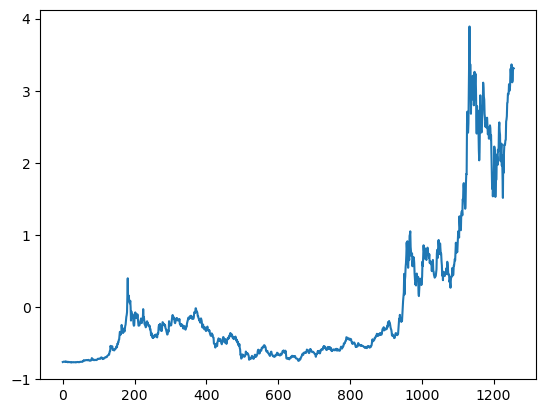

In [8]:
import matplotlib.pyplot as plt
plt.plot(Price)


In [6]:
def sim_markov_switching(mu1, sigma1, mu2, sigma2, p11, p22, n_steps, n_sim, x0=0.0):
    sims = []
    for _ in range(n_sim):
        x = [x0]
        state = 0  # start in regime 0
        for _ in range(n_steps - 1):
            if state == 0:
                x.append(x[-1] + np.random.normal(mu1, sigma1))
                state = 0 if np.random.rand() < p11 else 1
            else:
                x.append(x[-1] + np.random.normal(mu2, sigma2))
                state = 1 if np.random.rand() < p22 else 0
        sims.append(x)
    return np.array(sims)

In [7]:
sim_markov_switching(1.6779024835693605e-13,35.44,4.2460894248838396e-13,35.44,0.61,0.39,252,1)

array([[ 0.00000000e+00, -5.25342654e+01, -2.12652359e+01,
        -2.96446676e+01,  1.45711191e+01,  1.04596167e+02,
         8.89999319e+01,  7.35630122e+01, -2.94714096e-01,
         5.23660385e+00,  8.71434343e+01,  1.07957728e+02,
         1.14881719e+02,  6.50328263e+01,  8.80909591e+01,
         3.25550154e+01,  6.54746029e+01,  1.17442596e+02,
         1.16168206e+02,  1.14048044e+02,  1.02488735e+02,
         1.05216535e+02,  7.80397837e+01,  6.66869398e+01,
         9.49692867e+01,  8.35571652e+01,  9.46746394e+01,
         9.85786981e+01,  8.15876074e+01,  4.96956964e+01,
        -2.56590488e+00, -2.05342772e+01, -2.57534307e+01,
        -1.82052825e+01, -8.44837048e+01, -8.40869565e+01,
        -6.86387074e+01, -1.04248475e+02, -1.20014003e+02,
        -1.12306260e+02, -1.29108141e+02, -1.22419792e+02,
        -1.23385014e+02, -2.07359729e+02, -1.84548164e+02,
        -2.22858223e+02, -2.67678327e+02, -2.94600048e+02,
        -3.08637295e+02, -2.75904522e+02, -2.59557004e+0